# CSCI 381 - Deep Learning (Spring 2025) - Project 3

**Due Date: Friday, April 11 by 11:59 PM ET**

## Description
In this assignment you will develop a convolutional neural network to perform classification on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

## Instructions
**Please follow the instructions in Project 1A regarding how to add code to this project's notebook and associated Python files.**
1. In this assignment you will write code to construct machine learning models and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. If required (per the instructions in either *this file* or in the *code templates*), you will **only** utilize elementary functions in `Pytorch` to implement your neural network, e.g.,
    * *Matrix/Tensor Operations* such as `sum`, `mm`, `exp`, `log`, and `transpose`; and 
    * `clamp` - for implementing ReLU.

## Running Code
You will use the programming environment (Google Colab, Kaggle, or Local) that you configured in Project 0. The project is configured to use hardware acceleration when available. Instructions for Google Colab are included in the "Google Colab Setup" section.

## Expectations
You will **work independently** on the assignment. Please make use of the *Python/Pytorch/Data Science Reference Materials* posted on Brightspace, or **come to office hours should you need further assistance**.

## Submission Instructions
You will submit to Brightspace by the due date listed above:
   * Your completed Jupyter notebook, `convolutional_networks`, and `fully_connected_networks.py` files.
   * Your saved overfitting model `overfit_deepconvnet.pth` for the small CIFAR-10 dataset (Part 3.2).
   * Your saved best model `one_minute_deepconvnet.pth` for the CIFAR-10 dataset (Part 4.3).

## Grading Rubric
|**Part**|1.1|1.2|1.3|1.4|2.1|2.2|2.3|3.1|3.2|4.1|4.2|4.3|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|10|10|3|3|10|10|4|10|5|10|20|5|100|

<sub><sup>Modified by J. Gryak, Spring 2025. *Original Author*: [Justin C. Johnson](https://web.eecs.umich.edu/~justincj/)</sup></sub>

# Part 0: Assignment Setup

# Setup Code (All Environments)
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Jupyter Environment and Import Libraries

In [25]:
#install OpenCV if not yet installed
!pip install opencv-python

In [26]:
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from p3_utils import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Device/Precision Selection
[Pytorch](https://pytorch.org/) and other libraries ([Tensorflow](https://www.tensorflow.org/), [JAX](https://docs.jax.dev/en/latest/)) enable computations to be performed on GPUs. In order for your code to take advantage of this hardware the various matrices/tensors must either be created on those GPUs or copied to them. The libraries for this project have been designed so that you can specify the device to use globally and the various routines will take care of this technicality for you. **However, if you create any temporary tensors in your code, you must specify the device manually.**

You can use the conditional statement below to select the appropriate hardware for the project. Alternatively, you can simply hardcode your choice in the `device` variable. **Note that MPS devices only support 32-bit (single) precision.**

In [27]:
# Get cpu, gpu or mps device for training.

#if you have a CUDA-enabled nVidia GPU on your system, or are using Google Colab
if torch.cuda.is_available():
    DEVICE="cuda"
    DTYPE=torch.float64
#if you have a Mac with an M1 or greater processor and macOS 13 or greater
elif torch.backends.mps.is_available():
    DEVICE="mps"
    DTYPE=torch.float32
#otherwise use the system's CPU
else:
    DEVICE="cpu"
    DTYPE=torch.float64

print(f"Using {DEVICE} device with {DTYPE} precision.")

Using cuda device with torch.float64 precision.


### Google Colab Setup (Skip for Kaggle and Local Enviroments)
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
['convolutional_networks.ipynb', 'fully_connected_networks.ipynb', 'convolutional_networks.py', 'fully_connected_networks.py', 'p3_utils.py']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2025SP folder and put all the files under Project3 folder, then '2025SP/Project3'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025SP/Project3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from convolutional_networks.py!
Hello from p3_utils.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from convolutional_networks import hello_convolutional_networks
hello_convolutional_networks()

from p3_utils import hello_helper
hello_helper()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

# Part 1 - Convolutional Neural Networks (CNNs): Component Implementation

## Load and Preprocess the CIFAR-10 Dataset
Then, we will first load the CIFAR-10 dataset, the same as used in Project 1. The utility function `preprocess_cifar10` in `p3_utils` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

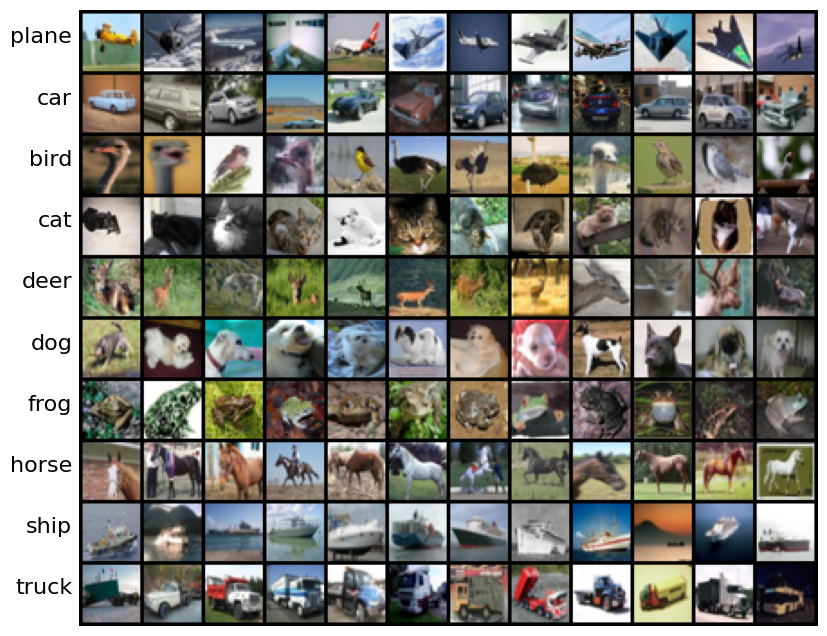

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [28]:
# Invoke the above function to get our data. 
import p3_utils

p3_utils.reset_seed(0)
data_dict = p3_utils.preprocess_cifar10(device=DEVICE,dtype=DTYPE,flatten=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results for images use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

### Convolutional Layer
We will package each new neural network operator in a class that defines a `forward` and `backward` function.

## Part 1.1 - Convolutional Layer: Forward
The core of a convolutional network is the convolution operation. Implement the forward pass for the convolution layer in the function `Conv.forward`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

After implementing the forward pass of the convolution operation, run the following to check your implementation. You should get a relative error less than `1e-7`.

In [29]:
from convolutional_networks import Conv

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=DTYPE, device=DEVICE).reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), dtype=DTYPE, device=DEVICE).reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, dtype=DTYPE, device=DEVICE)

conv_param = {'stride': 2, 'pad': 1}
out, _ = Conv.forward(x, w, b, conv_param)
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                              [-0.18387192, -0.2109216 ]],
                             [[ 0.21027089,  0.21661097],
                              [ 0.22847626,  0.23004637]],
                             [[ 0.50813986,  0.54309974],
                              [ 0.64082444,  0.67101435]]],
                            [[[-0.98053589, -1.03143541],
                              [-1.19128892, -1.24695841]],
                             [[ 0.69108355,  0.66880383],
                              [ 0.59480972,  0.56776003]],
                             [[ 2.36270298,  2.36904306],
                              [ 2.38090835,  2.38247847]]]], 
                          dtype=DTYPE, device=DEVICE,
            )

# Compare your output to ours; difference should be around e-8
print('Testing Conv.forward')
print('difference: ', p3_utils.rel_error(out, correct_out))

Testing Conv.forward
difference:  1.0141824738238694e-09


### Aside: Image Processing via Convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

In [30]:
!pip install imageio
!pip install pillow

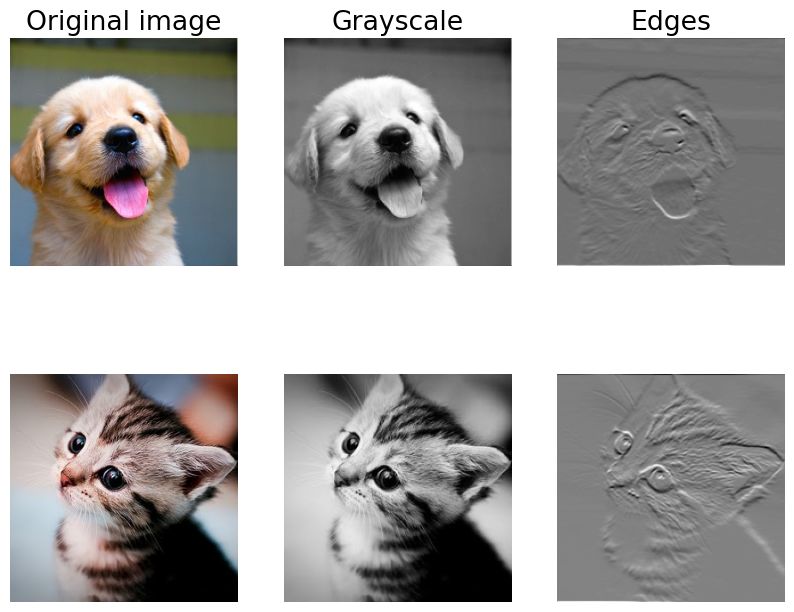

In [31]:
from imageio.v2 import imread
from PIL import Image
from torchvision.transforms import ToTensor

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
  """ Tiny helper to show images as uint8 and remove axis labels """
  if normalize:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

## Convolutional Layer: Backward
The backward pass for the convolution operation has been implemented for you by Prof. Gryak in the function `Conv.backward`. Take a look at the code to get a sense of how this works.

Run the following to verify that the manual backward pass is working correctly. You should get errors less than `1e-8`.

In [32]:
from convolutional_networks import Conv

reset_seed(0)
'''
x = torch.randn(4, 3, 5, 5, dtype=DTYPE, device=DEVICE)
w = torch.randn(2, 3, 3, 3, dtype=DTYPE, device=DEVICE)
b = torch.randn(2, dtype=DTYPE, device=DEVICE)
dout = torch.randn(4, 2, 5, 5, dtype=DTYPE, device=DEVICE)
conv_param = {'stride': 1, 'pad': 1}
'''
x = torch.randn(5, 3, 5, 5, dtype=DTYPE, device=DEVICE)
w = torch.randn(2, 3, 3, 3, dtype=DTYPE, device=DEVICE)
b = torch.randn(2, dtype=DTYPE, device=DEVICE)
dout = torch.randn(5, 2, 4, 4, dtype=DTYPE, device=DEVICE)
conv_param = {'stride': 2, 'pad': 2}

dx_num = p3_utils.compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = p3_utils.compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = p3_utils.compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error: ', p3_utils.rel_error(dx, dx_num))
print('dw error: ', p3_utils.rel_error(dw, dw_num))
print('db error: ', p3_utils.rel_error(db, db_num))

Testing Conv.backward function
dx error:  1.108532338825252e-09
dw error:  1.4341639199343773e-09
db error:  2.791832849375376e-10


## Part 1.2 - Max-pooling: Forward
Implement the forward pass for the max-pooling operation. Again, don't worry too much about computational efficiency.

After implementing the forward pass for max-pooling, run the following to check your implementation. You should get errors less than `1e-7`.


In [33]:
from convolutional_networks import MaxPool

reset_seed(0)
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), dtype=DTYPE, device=DEVICE).reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = MaxPool.forward(x, pool_param)

correct_out = torch.tensor([[[[-0.26315789, -0.24842105],
                              [-0.20421053, -0.18947368]],
                             [[-0.14526316, -0.13052632],
                              [-0.08631579, -0.07157895]],
                             [[-0.02736842, -0.01263158],
                              [ 0.03157895,  0.04631579]]],
                            [[[ 0.09052632,  0.10526316],
                              [ 0.14947368,  0.16421053]],
                             [[ 0.20842105,  0.22315789],
                              [ 0.26736842,  0.28210526]],
                             [[ 0.32631579,  0.34105263],
                              [ 0.38526316,  0.4       ]]]],
                           dtype=DTYPE, device=DEVICE)

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing MaxPool.forward function:')
print('difference: ', p3_utils.rel_error(out, correct_out))

Testing MaxPool.forward function:
difference:  5.921052675939009e-09


## Max-pooling: Backward
The backward pass for the max-pooling operation has been implemented for you by Prof. Gryak in the function `MaxPool.backward`. Take a look at the code to get a sense of how this works.

Run the following to verify that the manual backward pass is working correctly. You should get errors less than `1e-10`.

In [35]:
from convolutional_networks import MaxPool

reset_seed(0)
x = torch.randn(3, 2, 8, 8, dtype=DTYPE, device=DEVICE)
dout = torch.randn(3, 2, 4, 4, dtype=DTYPE, device=DEVICE)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = p3_utils.compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error: ', p3_utils.rel_error(dx, dx_num))

Testing MaxPool.backward function:
dx error:  6.653155794014975e-10


## Part 1.3 - Fast Layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers. Those can be found at the bottom of `convolutional_networks.py`

The fast convolution implementation depends on `torch.nn`.

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass receives upstream derivatives and the cache object and produces gradients with respect to the data and weights.

```python
class FastConv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
    layer.weight = torch.nn.Parameter(w)
    layer.bias = torch.nn.Parameter(b)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, w, b, conv_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, _, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
      dw = layer.weight.grad.detach()
      db = layer.bias.grad.detach()
      layer.weight.grad = layer.bias.grad = None
    except RuntimeError:
      dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)
    return dx, dw, db


class FastMaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']
    layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, pool_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
    except RuntimeError:
      dx = torch.zeros_like(tx)
    return dx
```


We will now compare three different implementations of convolution (both forward and backward):

1. Your naive, non-vectorized implementation on CPU
2. The fast, vectorized implementation on CPU
3. The fast, vectorized implementation on GPU

The differences between your implementation and FastConv should be less than `1e-10`. When moving from your implementation to FastConv CPU, you will likely see speedups of at least 100x. When comparing your implementation to FastConv Hardware Accelerated (HWA), you will likely see speedups of more than 500x. (These speedups are not hard requirements for this assignment since we are not asking you to write any vectorized implementations.)

In [36]:
# Rel errors should be around e-11 or less
from convolutional_networks import Conv, FastConv

reset_seed(0)
x = torch.randn(10, 3, 31, 31, dtype=DTYPE, device='cpu')
w = torch.randn(25, 3, 3, 3, dtype=DTYPE, device='cpu')
b = torch.randn(25, dtype=DTYPE, device='cpu')
dout = torch.randn(10, 25, 16, 16, dtype=DTYPE, device='cpu')
x_hwa, w_hwa, b_hwa, dout_hwa = x.to(DEVICE), w.to(DEVICE), b.to(DEVICE), dout.to(DEVICE)
conv_param = {'stride': 2, 'pad': 1}

t0 = time.time()
out_naive, cache_naive = Conv.forward(x, w, b, conv_param)
t1 = time.time()
out_fast, cache_fast = FastConv.forward(x, w, b, conv_param)
t2 = time.time()
out_fast_hwa, cache_fast_hwa = FastConv.forward(x_hwa, w_hwa, b_hwa, conv_param)
t3 = time.time()

print('Testing FastConv.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast HWA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup HWA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', p3_utils.rel_error(out_naive, out_fast))
print('difference HWA: ', p3_utils.rel_error(out_naive, out_fast_hwa.to(out_naive.device)))

t0 = time.time()
dx_naive, dw_naive, db_naive = Conv.backward(dout, cache_naive)
t1 = time.time()
dx_fast, dw_fast, db_fast = FastConv.backward(dout, cache_fast)
t2 = time.time()
dx_fast_hwa, dw_fast_hwa, db_fast_hwa = FastConv.backward(dout_hwa, cache_fast_hwa)
t3 = time.time()

print('\nTesting FastConv.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast HWA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup HWA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', p3_utils.rel_error(dx_naive, dx_fast))
print('dw difference: ', p3_utils.rel_error(dw_naive, dw_fast))
print('db difference: ', p3_utils.rel_error(db_naive, db_fast))
print('dx difference HWA: ', p3_utils.rel_error(dx_naive, dx_fast_hwa.to(dx_naive.device)))
print('dw difference HWA: ', p3_utils.rel_error(dw_naive, dw_fast_hwa.to(dw_naive.device)))
print('db difference HWA: ', p3_utils.rel_error(db_naive, db_fast_hwa.to(db_naive.device)))

Testing FastConv.forward:
Naive: 2.322947s
Fast: 0.008053s
Fast HWA: 0.013910s
Speedup: 288.446533x
Speedup HWA: 167.003428x
Difference:  1.8967437916230627e-16
difference HWA:  1.8967437916230627e-16

Testing FastConv.backward:
Naive: 1.051022s
Fast: 0.010301s
Fast HWA: 0.026132s
Speedup: 102.027565x
Speedup HWA: 40.220293x
dx difference:  7.776651591696694e-17
dw difference:  2.4207217602568154e-16
db difference:  0.0
dx difference HWA:  3.4994932162635126e-16
dw difference HWA:  1.5561782744508106e-16
db difference HWA:  1.0951849832594255e-16


We will now similarly compare your naive implementation of max pooling against the fast implementation. You should see differences of 0 between your implementation and the fast implementation.

When comparing your implementation against FastMaxPool on CPU, you will likely see speedups of more than 100x. When comparing your implementation against FastMaxPool on GPU, you will likely see speedups of more than 500x.

In [37]:
# Relative errors should be close to 0.0
from convolutional_networks import Conv, MaxPool, FastConv, FastMaxPool


reset_seed(0)
x = torch.randn(40, 3, 32, 32, dtype=DTYPE, device='cpu')
dout = torch.randn(40, 3, 16, 16, dtype=DTYPE, device='cpu')
x_hwa, dout_hwa = x.to(DEVICE), dout.to(DEVICE)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time.time()
out_naive, cache_naive = MaxPool.forward(x, pool_param)
t1 = time.time()
out_fast, cache_fast = FastMaxPool.forward(x, pool_param)
t2 = time.time()
out_fast_hwa, cache_fast_hwa = FastMaxPool.forward(x_hwa, pool_param)
t3 = time.time()

print('Testing FastMaxPool.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast HWA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup HWA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', p3_utils.rel_error(out_naive, out_fast))
print('difference HWA: ', p3_utils.rel_error(out_naive, out_fast_hwa.to(out_naive.device)))

t0 = time.time()
dx_naive = MaxPool.backward(dout, cache_naive)
t1 = time.time()
dx_fast = FastMaxPool.backward(dout, cache_fast)
t2 = time.time()
dx_fast_hwa = FastMaxPool.backward(dout_hwa, cache_fast_hwa)
t3 = time.time()

print('\nTesting FastMaxPool.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast HWA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup HWA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', p3_utils.rel_error(dx_naive, dx_fast))
print('dx difference HWA: ', p3_utils.rel_error(dx_naive, dx_fast_hwa.to(dx_naive.device)))

Testing FastMaxPool.forward:
Naive: 0.711124s
Fast: 0.005788s
Fast HWA: 0.000430s
Speedup: 122.865011x
Speedup HWA: 1655.200333x
Difference:  0.0
difference HWA:  0.0

Testing FastMaxPool.backward:
Naive: 0.592122s
Fast: 0.000718s
Fast HWA: 0.000609s
Speedup: 824.548473x
Speedup HWA: 971.651017x
dx difference:  0.0
dx difference HWA:  0.0


## Part 1.4 - Convolutional "Sandwich" Layers
"Sandwich" layers combine multiple operations into commonly used patterns which can then be used to construct modular networks. Below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We've included them at the bottom of `covolutional_networks.py`. 

1) Implement the `forward` and `backward` methods of the `ReLU` class in `fully_connected_networks.py` (you may reuse your code from Project 2).
2) Run the cells below to to verify that the these "sandwich" layers are working. You should see errors less than `1e-7`.

```python
class Conv_ReLU(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    out, relu_cache = ReLU.forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db


class Conv_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, conv_param, pool_param):
    """
    A convenience layer that performs a convolution, a ReLU, and a pool.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    s, relu_cache = ReLU.forward(a)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    da = ReLU.backward(ds, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db
```

In [38]:
from convolutional_networks import Conv_ReLU, Conv_ReLU_Pool
reset_seed(0)

# Test Conv ReLU
x = torch.randn(2, 3, 8, 8, dtype=DTYPE, device=DEVICE)
w = torch.randn(3, 3, 3, 3, dtype=DTYPE, device=DEVICE)
b = torch.randn(3, dtype=DTYPE, device=DEVICE)
dout = torch.randn(2, 3, 8, 8, dtype=DTYPE, device=DEVICE)
conv_param = {'stride': 1, 'pad': 1}

out, cache = Conv_ReLU.forward(x, w, b, conv_param)
dx, dw, db = Conv_ReLU.backward(dout, cache)

dx_num = p3_utils.compute_numeric_gradient(lambda x: Conv_ReLU.forward(x, w, b, conv_param)[0], x, dout)
dw_num = p3_utils.compute_numeric_gradient(lambda w: Conv_ReLU.forward(x, w, b, conv_param)[0], w, dout)
db_num = p3_utils.compute_numeric_gradient(lambda b: Conv_ReLU.forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing Conv_ReLU:')
print('dx error: ', p3_utils.rel_error(dx_num, dx))
print('dw error: ', p3_utils.rel_error(dw_num, dw))
print('db error: ', p3_utils.rel_error(db_num, db))

# Test Conv ReLU Pool
x = torch.randn(2, 3, 16, 16, dtype=DTYPE, device=DEVICE)
w = torch.randn(3, 3, 3, 3, dtype=DTYPE, device=DEVICE)
b = torch.randn(3, dtype=DTYPE, device=DEVICE)
dout = torch.randn(2, 3, 8, 8, dtype=DTYPE, device=DEVICE)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)
dx, dw, db = Conv_ReLU_Pool.backward(dout, cache)

dx_num = p3_utils.compute_numeric_gradient(lambda x: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = p3_utils.compute_numeric_gradient(lambda w: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = p3_utils.compute_numeric_gradient(lambda b: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print()
print('Testing Conv_ReLU_Pool')
print('dx error: ', p3_utils.rel_error(dx_num, dx))
print('dw error: ', p3_utils.rel_error(dw_num, dw))
print('db error: ', p3_utils.rel_error(db_num, db))


Testing Conv_ReLU:
dx error:  1.8037001509296748e-09
dw error:  1.2470995998634857e-09
db error:  1.1230402096612364e-09

Testing Conv_ReLU_Pool
dx error:  1.5915037060449427e-09
dw error:  1.8962680214651407e-09
db error:  5.05984212319748e-09


# Part 2 - Three-layer Convolutional Network

## Part 2.1 - Implement a Three-layer Convolutional Network
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

1) Implement the `forward` and `backward` methods of the `Linear` class in `fully_connected_networks.py` (you may reuse your code from Project 2).
2) Complete the implementation of the `ThreeLayerConvNet` class. We STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity Check: Loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [39]:
from convolutional_networks import ThreeLayerConvNet

reset_seed(0)
model = ThreeLayerConvNet(dtype=DTYPE, device=DEVICE)

N = 50
X = torch.randn(N, 3, 32, 32, dtype=DTYPE, device=DEVICE)
y = torch.randint(10, size=(N,), dtype=torch.int64, device=DEVICE)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.3025859483479274
Initial loss (with regularization):  2.7156707138622465


## Sanity Check: Gradient
After the loss looks reasonable, use numeric gradient checking to ensure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artificial data and a small number of neurons per layer.

You should see errors less than `1e-5`.

In [40]:
from convolutional_networks import ThreeLayerConvNet

num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.0
num_classes = 10
reset_seed(0)
X = torch.randn(num_inputs, *input_dims, dtype=DTYPE, device=DEVICE)
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device=DEVICE)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, reg=reg, dtype=DTYPE, device=DEVICE)
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = p3_utils.compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, p3_utils.rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.851376e-08
W2 max relative error: 7.622434e-08
W3 max relative error: 4.168769e-09
b1 max relative error: 1.252231e-08
b2 max relative error: 2.934901e-08
b3 max relative error: 3.205744e-09


## Part 2.2 - Overfiting on a Small Dataset
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

Throughout this project we will be using the `Solver` class to train methods using some variant of minibatch stochastic gradient descent (SGD). Implement the `adam` update rule in `fully_connected_networks.py` prior to training below.

In [41]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3, dtype=torch.float32, device=DEVICE)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=1,
                device=DEVICE)
solver.train()

(Time 0.01 sec; Iteration 1 / 60) loss: 2.302585
(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.101400
(Time 0.08 sec; Iteration 2 / 60) loss: 2.300027
(Epoch 1 / 30) train acc: 0.170000; val_acc: 0.137000
(Time 0.16 sec; Iteration 3 / 60) loss: 2.285712
(Time 0.16 sec; Iteration 4 / 60) loss: 2.274528
(Epoch 2 / 30) train acc: 0.190000; val_acc: 0.139800
(Time 0.24 sec; Iteration 5 / 60) loss: 2.209003
(Time 0.24 sec; Iteration 6 / 60) loss: 2.223748
(Epoch 3 / 30) train acc: 0.210000; val_acc: 0.114200
(Time 0.31 sec; Iteration 7 / 60) loss: 2.304927
(Time 0.31 sec; Iteration 8 / 60) loss: 2.129336
(Epoch 4 / 30) train acc: 0.200000; val_acc: 0.108800
(Time 0.38 sec; Iteration 9 / 60) loss: 2.180076
(Time 0.39 sec; Iteration 10 / 60) loss: 2.074004
(Epoch 5 / 30) train acc: 0.290000; val_acc: 0.143900
(Time 0.46 sec; Iteration 11 / 60) loss: 2.088579
(Time 0.46 sec; Iteration 12 / 60) loss: 2.023115
(Epoch 6 / 30) train acc: 0.330000; val_acc: 0.151300
(Time 0.53 sec; Iteration 13 / 

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

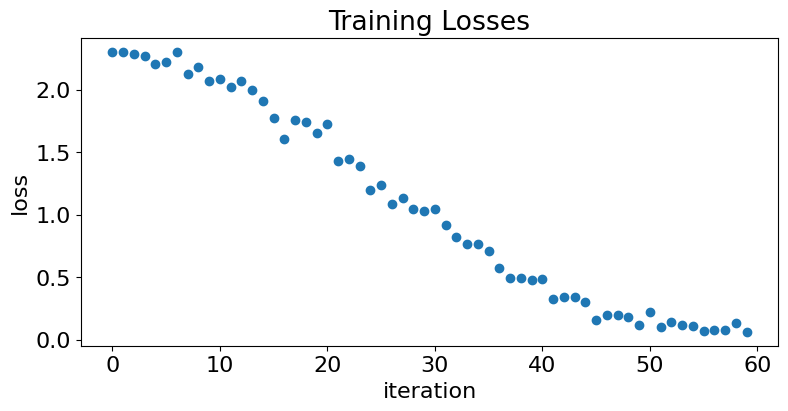

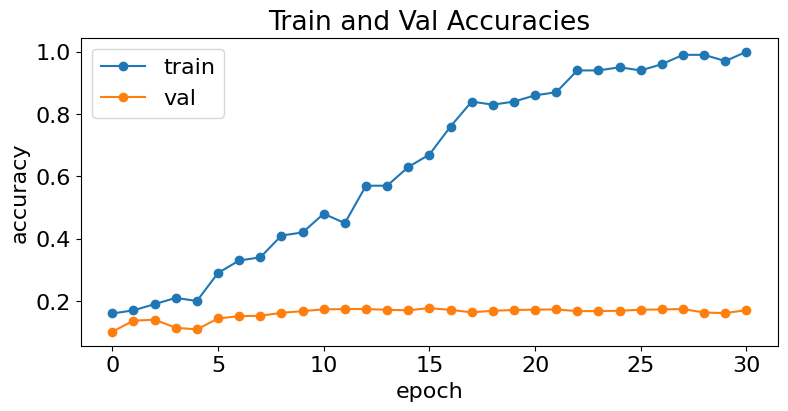

In [42]:
plt.title('Training Losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val Accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Part 2.3 - Train the Network
By training the three-layer convolutional network for one epoch, you should achieve greater than 50% accuracy on the training set:

In [43]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(0)

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, dtype=torch.float, device=DEVICE)

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=50, device=DEVICE)
solver.train()

(Time 0.01 sec; Iteration 1 / 625) loss: 2.306687
(Epoch 0 / 1) train acc: 0.100000; val_acc: 0.093300
(Time 0.38 sec; Iteration 51 / 625) loss: 2.312648
(Time 0.65 sec; Iteration 101 / 625) loss: 2.098083
(Time 0.92 sec; Iteration 151 / 625) loss: 1.779771
(Time 1.19 sec; Iteration 201 / 625) loss: 1.710157
(Time 1.45 sec; Iteration 251 / 625) loss: 1.727073
(Time 1.72 sec; Iteration 301 / 625) loss: 1.705343
(Time 1.99 sec; Iteration 351 / 625) loss: 1.568846
(Time 2.26 sec; Iteration 401 / 625) loss: 1.594543
(Time 2.53 sec; Iteration 451 / 625) loss: 1.644078
(Time 2.79 sec; Iteration 501 / 625) loss: 1.558164
(Time 3.06 sec; Iteration 551 / 625) loss: 1.621899
(Time 3.32 sec; Iteration 601 / 625) loss: 1.554850
(Epoch 1 / 1) train acc: 0.524000; val_acc: 0.493200


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

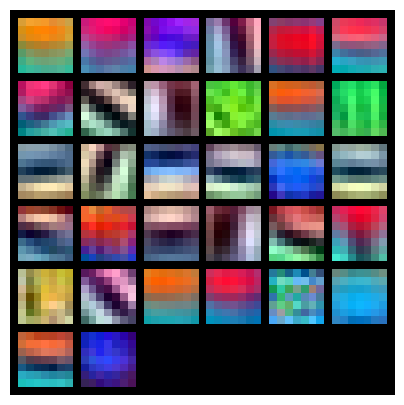

In [44]:
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Part 3 - Deep Convolutional Network
Next you will implement a deep convolutional network with an arbitrary number of conv layers in **VGGNet** style.

## Part 3.1 - Implement a VGGNet-style CNN
Read through the `DeepConvNet` class.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing Kaiming initialization; we will add that feature soon. Again, we STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation.

## Sanity Check: Loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [45]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam

reset_seed(0)
input_dims = (3, 32, 32)
model = DeepConvNet(num_filters=[8, 64], max_pools=[0, 1], dtype=DTYPE, device=DEVICE)

N = 50
X = torch.randn(N, *input_dims, dtype=DTYPE, device=DEVICE)
y = torch.randint(10, size=(N,), dtype=torch.int64, device=DEVICE)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 1.
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.3025851202631697
Initial loss (with regularization):  2.3482181999566953


## Sanity Check: Gradient
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artificial data and a small number of neurons at each layer.

You should see relative errors less than `1e-5`. 

In [46]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam

reset_seed(0)
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(N, *input_dims, dtype=DTYPE, device=DEVICE)
y = torch.randint(10, size=(N,), dtype=torch.int64, device=DEVICE)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg,
                      weight_scale=5e-2, dtype=DTYPE, device=DEVICE)

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-6
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = p3_utils.compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, p3_utils.rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
W1 max relative error: 5.912415e-07
W2 max relative error: 8.190183e-07
W3 max relative error: 5.317616e-07
W4 max relative error: 6.344352e-07
b1 max relative error: 6.956690e-07
b2 max relative error: 4.282076e-07
b3 max relative error: 2.831506e-08
b4 max relative error: 1.407349e-08

Running check with reg =  3.14
W1 max relative error: 1.185937e-08
W2 max relative error: 9.768251e-09
W3 max relative error: 1.343384e-08
W4 max relative error: 1.000000e+00
b1 max relative error: 1.326121e-06
b2 max relative error: 9.922034e-07
b3 max relative error: 3.703688e-07
b4 max relative error: 4.369870e-08


## Part 3.2 - Overfiting on a Small Dataset
As another sanity check, make sure you can overfit a small dataset of 50 images. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 30 epochs.

(Time 0.02 sec; Iteration 1 / 150) loss: 2.366917
(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.101600
(Epoch 1 / 30) train acc: 0.120000; val_acc: 0.102600
(Epoch 2 / 30) train acc: 0.140000; val_acc: 0.112100
(Time 0.63 sec; Iteration 11 / 150) loss: 2.241986
(Epoch 3 / 30) train acc: 0.160000; val_acc: 0.095200
(Epoch 4 / 30) train acc: 0.180000; val_acc: 0.096500
(Time 1.05 sec; Iteration 21 / 150) loss: 2.337459
(Epoch 5 / 30) train acc: 0.260000; val_acc: 0.131400
(Epoch 6 / 30) train acc: 0.360000; val_acc: 0.153000
(Time 1.47 sec; Iteration 31 / 150) loss: 2.266803
(Epoch 7 / 30) train acc: 0.280000; val_acc: 0.113300
(Epoch 8 / 30) train acc: 0.540000; val_acc: 0.183600
(Time 1.90 sec; Iteration 41 / 150) loss: 1.565539
(Epoch 9 / 30) train acc: 0.560000; val_acc: 0.192800
(Epoch 10 / 30) train acc: 0.580000; val_acc: 0.167400
(Time 2.32 sec; Iteration 51 / 150) loss: 1.623140
(Epoch 11 / 30) train acc: 0.540000; val_acc: 0.168100
(Epoch 12 / 30) train acc: 0.800000; val_acc:

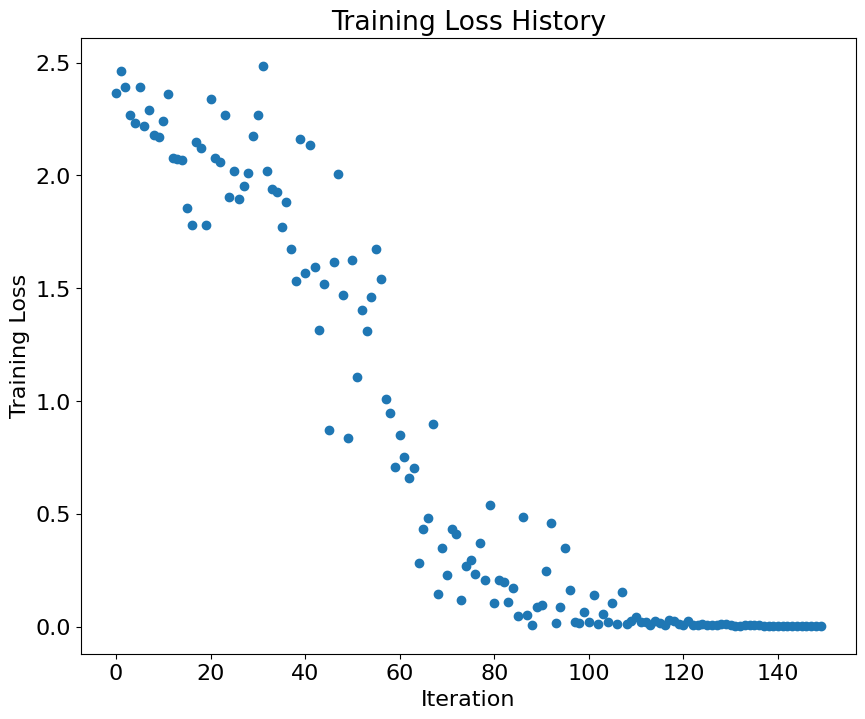

1.0


In [47]:
# TODO: Use a DeepConvNet to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
from convolutional_networks import DeepConvNet, find_overfit_parameters
from fully_connected_networks import adam

reset_seed(0)
num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = small_data['X_train'].shape[1:]


# Update the parameters in find_overfit_parameters in convolutional_networks.py
weight_scale, learning_rate = find_overfit_parameters()


model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, dtype=torch.float32, device=DEVICE)
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device=DEVICE,
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training Loss History')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

val_acc = solver.check_accuracy(
                        solver.X_train, solver.y_train, num_samples=solver.num_train_samples
                    )
print(val_acc)

If you're happy with the model's performance, *run the following cell* to save it. 

We will also reload the model and run it on the training data to verify it has the correct weights.

In [48]:
try:
    path = os.path.join(GOOGLE_DRIVE_PATH, 'overfit_deepconvnet.pth')
except NameError:
    path = 'overfit_deepconvnet.pth'
solver.model.save(path)

# Create a new instance
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, dtype=torch.float32, device=DEVICE)
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device=DEVICE,
         )


# Load model
solver.model.load(path, dtype=torch.float32, device=DEVICE)

# Evaluate on validation set
accuracy = solver.check_accuracy(small_data['X_train'], small_data['y_train'])
print(f"Saved model's accuracy on training is {accuracy}")

Saved in overfit_deepconvnet.pth
load checkpoint file: overfit_deepconvnet.pth
Saved model's accuracy on training is 1.0


/kaggle/input/temp45/convolutional_networks.py:497: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location='cpu')


# Part 4: Kaiming Initialization
So far, you manually tuned the weight scale and for weight initialization.
However, this is inefficient when it comes to training deep neural networks; practically, as your weight matrix is larger, the weight scale should be small.
Below you will implement [Kaiming initialization](http://arxiv-web3.library.cornell.edu/abs/1502.01852). For more details, refer to [cs231n note](http://cs231n.github.io/neural-networks-2/#init) and [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

## Part 4.1 - Convolutional Nets with Kaiming initialization
Now that you have a working implementation for Kaiming initialization, go back to your [`DeepConvnet`](#scrollTo=Ah-_nwx2BSxl). Modify your implementation to add Kaiming initialization.

Concretely, when the `weight_scale` is set to `'kaiming'` in the constructor, you should initialize weights of convolutional and linear layers using `kaiming_initializer`. Once you are done, run the following to see the effect of Kaiming initialization in deep CNNs.

In this experiment, we train a 31-layer network with four different weight initialization schemes. Among them, only the Kaiming initialization method should achieve a non-random accuracy after one epoch of training.

You may see `nan` loss when `weight_scale` is large, this shows a catastrophe of inappropriate weight initialization.

**Note**: Implement the `sgd_momentum` update rule in `fully_connected_networks.py` prior to training below.

In [49]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import sgd_momentum
reset_seed(0)

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
  print('Solver with weight scale: ', weight_scale)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                      max_pools=[9, 19],
                      weight_scale=weight_scale,
                      reg=1e-5, 
                      dtype=torch.float32,
                      device=DEVICE
                      )

  solver = Solver(model, small_data,
                  num_epochs=1, batch_size=128,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': 2e-3,
                  },
                  print_every=20, device=DEVICE)
  solver.train()
  solvers.append(solver)

Solver with weight scale:  kaiming
(Time 0.05 sec; Iteration 1 / 78) loss: 2.349008
(Epoch 0 / 1) train acc: 0.126000; val_acc: 0.115000
(Time 3.09 sec; Iteration 21 / 78) loss: 2.333812
(Time 4.05 sec; Iteration 41 / 78) loss: 2.318295
(Time 5.01 sec; Iteration 61 / 78) loss: 2.215599
(Epoch 1 / 1) train acc: 0.220000; val_acc: 0.218200
Solver with weight scale:  0.1
(Time 0.05 sec; Iteration 1 / 78) loss: 82.162544
(Epoch 0 / 1) train acc: 0.095000; val_acc: 0.097700
(Time 3.03 sec; Iteration 21 / 78) loss: nan
(Time 3.97 sec; Iteration 41 / 78) loss: nan
(Time 4.90 sec; Iteration 61 / 78) loss: nan
(Epoch 1 / 1) train acc: 0.092000; val_acc: 0.101400
Solver with weight scale:  0.01
(Time 0.05 sec; Iteration 1 / 78) loss: 2.304123
(Epoch 0 / 1) train acc: 0.120000; val_acc: 0.100300
(Time 3.05 sec; Iteration 21 / 78) loss: 2.304194
(Time 3.98 sec; Iteration 41 / 78) loss: 2.303957
(Time 4.92 sec; Iteration 61 / 78) loss: 2.303860
(Epoch 1 / 1) train acc: 0.111000; val_acc: 0.100300
S

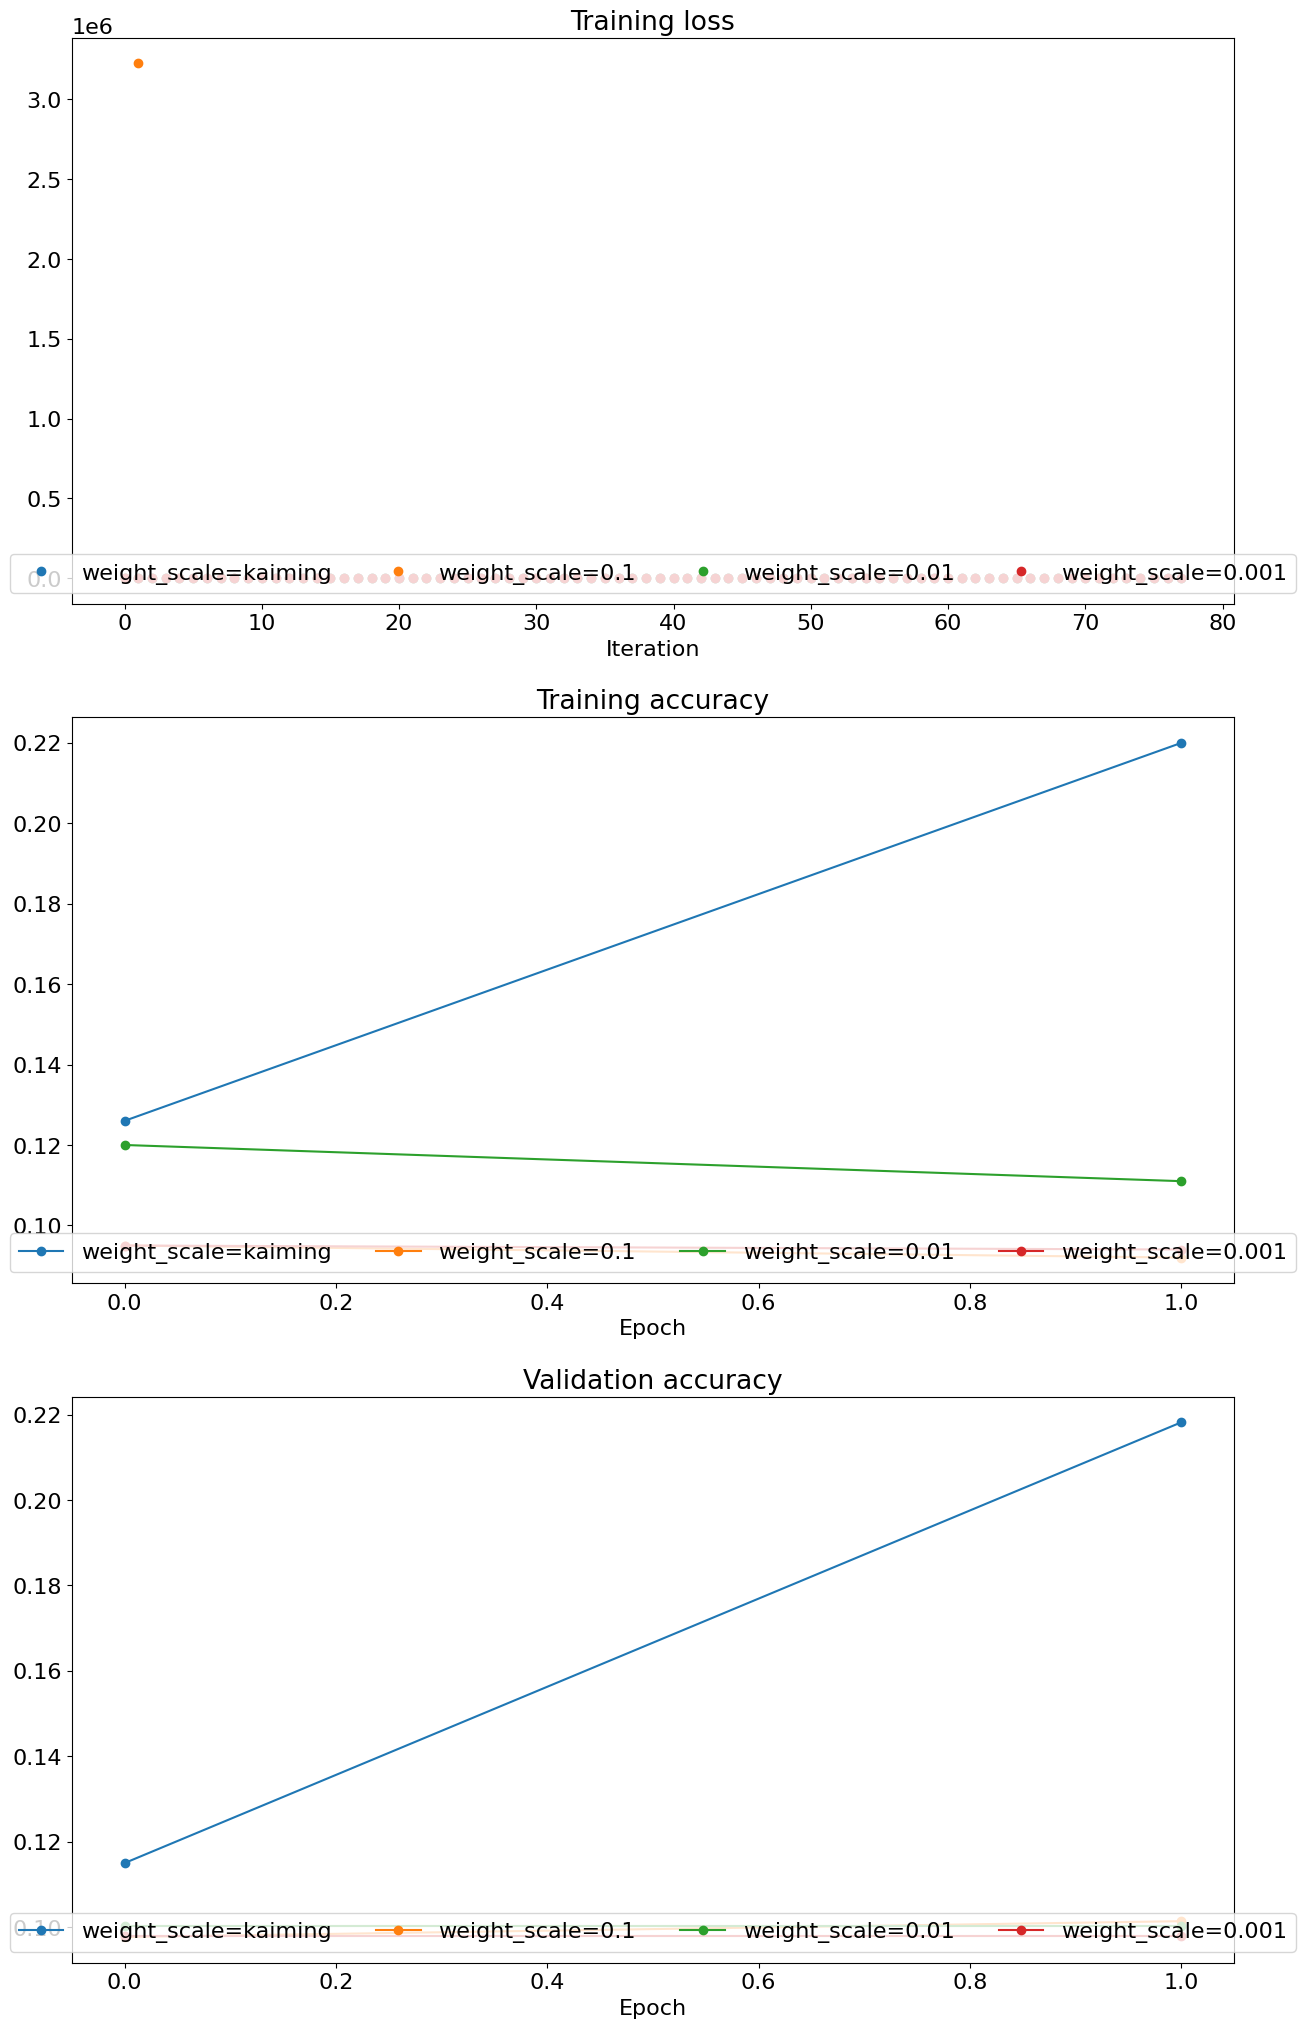

In [50]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, marker='-o'):
  plt.title(title)
  plt.xlabel(xlabel)
  for solver, label in zip(solvers, labels):    
    data = plot_fn(solver)
    label = 'weight_scale=' + str(label)
    plt.plot(data, marker, label=label)
  plt.legend(loc='lower center', ncol=len(solvers))

plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, weight_scales,
                            lambda x: x.loss_history, marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.train_acc_history)
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.val_acc_history)
plt.gcf().set_size_inches(15, 25)
plt.show()

## Part 4.2 - Train a Good Model!
Train the best DeepConvNet model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 71% accuracy on the validation set using a convolutional net, within 60 seconds of training.

**Implement** `create_convolutional_solver_instance` while making sure to use the initialize your model with the input `dtype` and `device`, as well as initializing the solver on the input `device`. 

*Hint 1*: Your model does not have to be too deep.

*Hint 2*: We used `batch_size = 128` for training a model with $>74\%$ validation accuracy. You don't have to follow this, but it would save you time for hyperparameter search.

*Hint 3*: Feel free to use the optimizers you've already implemented, e.g., `adam`. 

In [51]:
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

#CUDA-specific backend directives
if DEVICE == 'cuda':
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

solver = create_convolutional_solver_instance(data_dict, torch.float32, DEVICE)

solver.train(time_limit=60)

#CUDA-specific backend directives
if DEVICE == 'cuda':
    torch.backends.cudnn.benchmark = False

(Time 0.01 sec; Iteration 1 / 3744) loss: 2.599726
(Epoch 0 / 12) train acc: 0.163000; val_acc: 0.150700
(Time 0.62 sec; Iteration 51 / 3744) loss: 1.800908
(Time 1.03 sec; Iteration 101 / 3744) loss: 1.439880
(Time 1.44 sec; Iteration 151 / 3744) loss: 1.434462
(Time 1.84 sec; Iteration 201 / 3744) loss: 1.298828
(Time 2.25 sec; Iteration 251 / 3744) loss: 1.569463
(Time 2.65 sec; Iteration 301 / 3744) loss: 1.261241
(Epoch 1 / 12) train acc: 0.637000; val_acc: 0.611700
(Time 3.25 sec; Iteration 351 / 3744) loss: 1.317188
(Time 3.65 sec; Iteration 401 / 3744) loss: 1.115432
(Time 4.05 sec; Iteration 451 / 3744) loss: 1.204626
(Time 4.46 sec; Iteration 501 / 3744) loss: 1.320887
(Time 4.87 sec; Iteration 551 / 3744) loss: 1.250802
(Time 5.27 sec; Iteration 601 / 3744) loss: 1.004922
(Epoch 2 / 12) train acc: 0.717000; val_acc: 0.659900
(Time 5.88 sec; Iteration 651 / 3744) loss: 1.169854
(Time 6.29 sec; Iteration 701 / 3744) loss: 1.005595
(Time 6.69 sec; Iteration 751 / 3744) loss: 0.

# Part 4.3 - The Grand Finale:  Test Your Model!
Run your best model on the validation and test sets. You should achieve above 71% accuracy on the validation set and 70% accuracy on the test set.

**Note**: Do not run this until you are satisfied with your model's performance in Part 4.2 - otherwise this will result in data leakage. You must remove the text `**REMOVE AFTER COMPLETING 4.2**` for the cell below to run.

(Our best model gets 75.4% validation accuracy and 75.0% test accuracy -- can you beat ours?)

In [52]:
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Validation set accuracy:  0.7387999892234802
Test set accuracy:  0.7307999730110168


If you're happy with the model's performance, **run the following cell to save it**. 

We will also reload the model and run it on the training data to verify it has the correct weights.

In [53]:
try:
    path = os.path.join(GOOGLE_DRIVE_PATH, 'one_minute_deepconvnet.pth')
except NameError:
    path = 'one_minute_deepconvnet.pth'
solver.model.save(path)

# Create a new instance
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

solver = create_convolutional_solver_instance(data_dict, torch.float32, DEVICE)

# Load model
solver.model.load(path, dtype=torch.float32, device=DEVICE)

# Evaluate on validation set
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Saved in one_minute_deepconvnet.pth
load checkpoint file: one_minute_deepconvnet.pth
Validation set accuracy:  0.7387999892234802
Test set accuracy:  0.7307999730110168
